In [1]:
import pandas as pd 

df = pd.read_csv("../data/processed/order_breakdown.csv")

df.head()

,Unnamed: 0,kolejności,Anon,Data zakupu,bottle_units,pitcher_units,accessory_units,other_units,bottle_filter_units,pitcher_filter_units,bottle_included_filter_units,total_bottle_filters
0,0,68640194,ANON_0001,2022-11-09,1,0,1,0,4,0,1,5
1,1,69067553,ANON_0002,2022-11-11,0,0,1,0,2,0,0,2
2,2,69571584,ANON_0003,2022-11-13,2,0,0,1,9,0,2,11
3,3,69716225,ANON_0004,2022-11-14,0,1,0,0,0,2,0,0
4,4,69779965,ANON_0005,2022-11-14,0,1,0,0,0,0,0,0


In [2]:
import pandas as pd
import numpy as np

# If you saved to disk, load it (example)
# order_level = pd.read_parquet("order_level.parquet")

order_level = df.copy()

# ---- adapt these to your actual column names ----
DATE_COL = "Data zakupu"
CUST_COL = "Anon"   # could be email, customer_id, etc.
ORDER_COL = "kolejności"

COUNT_COLS = [
    "bottle_units",
    "pitcher_units",
    "bottle_filter_units",
    "pitcher_filter_units",
    "accessory_units",
    "other_units",
]

# Types
order_level[DATE_COL] = pd.to_datetime(order_level[DATE_COL], errors="coerce")
for c in COUNT_COLS:
    if c in order_level.columns:
        order_level[c] = pd.to_numeric(order_level[c], errors="coerce").fillna(0).astype(int)

# Drop rows we cannot timeline
order_level = order_level.dropna(subset=[CUST_COL, DATE_COL])

# Sort for timeline operations
order_level = order_level.sort_values([CUST_COL, DATE_COL, ORDER_COL])




In [3]:
'''Build the customer timeline table (one row per customer-order)'''

tl = order_level[[CUST_COL, ORDER_COL, DATE_COL] + [c for c in COUNT_COLS if c in order_level.columns]].copy()

# Helpful flags
tl["bottle_filter_purchase"]  = tl.get("bottle_filter_units", 0)  > 0
tl["pitcher_filter_purchase"] = tl.get("pitcher_filter_units", 0) > 0
tl["any_filter_purchase"]     = tl["bottle_filter_purchase"] | tl["pitcher_filter_purchase"]
tl["equipment_purchase"]      = (tl.get("bottle_units",0) > 0) | (tl.get("pitcher_units",0) > 0)

tl.head()


,Anon,kolejności,Data zakupu,bottle_units,pitcher_units,bottle_filter_units,pitcher_filter_units,accessory_units,other_units,bottle_filter_purchase,pitcher_filter_purchase,any_filter_purchase,equipment_purchase
0,ANON_0001,68640194,2022-11-09,1,0,4,0,1,0,True,False,True,True
1,ANON_0002,69067553,2022-11-11,0,0,2,0,1,0,True,False,True,False
2,ANON_0003,69571584,2022-11-13,2,0,9,0,0,1,True,False,True,True
3,ANON_0004,69716225,2022-11-14,0,1,0,2,0,0,False,True,True,True
8428,ANON_0004,222182927,2024-09-16,2,0,16,0,0,0,True,False,True,True


In [4]:
'''Customer-level cumulative stock (equipment + filters)'''

# Cumulative equipment
tl["cum_bottle_units"]  = tl.groupby(CUST_COL)["bottle_units"].cumsum() if "bottle_units" in tl else 0
tl["cum_pitcher_units"] = tl.groupby(CUST_COL)["pitcher_units"].cumsum() if "pitcher_units" in tl else 0

# Cumulative filters acquired
tl["cum_bottle_filter_units_acq"]  = tl.groupby(CUST_COL)["bottle_filter_units"].cumsum() if "bottle_filter_units" in tl else 0
tl["cum_pitcher_filter_units_acq"] = tl.groupby(CUST_COL)["pitcher_filter_units"].cumsum() if "pitcher_filter_units" in tl else 0

tl[[CUST_COL, DATE_COL, "cum_bottle_units", "cum_bottle_filter_units_acq", "cum_pitcher_units", "cum_pitcher_filter_units_acq"]].head(10)


,Anon,Data zakupu,cum_bottle_units,cum_bottle_filter_units_acq,cum_pitcher_units,cum_pitcher_filter_units_acq
0,ANON_0001,2022-11-09,1,4,0,0
1,ANON_0002,2022-11-11,0,2,0,0
2,ANON_0003,2022-11-13,2,9,0,0
3,ANON_0004,2022-11-14,0,0,1,2
8428,ANON_0004,2024-09-16,2,16,1,2
4,ANON_0005,2022-11-14,0,0,1,0
5,ANON_0006,2022-11-14,0,3,1,8
764,ANON_0006,2023-03-22,2,10,1,8
1765,ANON_0006,2023-07-14,3,17,1,8
5499,ANON_0006,2024-03-27,3,26,1,8


In [5]:
'''Time between filter purchases (cadence signals)'''

def add_purchase_gaps(df, purchase_flag_col, date_col=DATE_COL, out_col="gap_days"):
    d = df.loc[df[purchase_flag_col]].copy()
    d[out_col] = d.groupby(CUST_COL)[date_col].diff().dt.days
    return d[[CUST_COL, ORDER_COL, date_col, out_col]]

bottle_gaps  = add_purchase_gaps(tl, "bottle_filter_purchase",  out_col="bottle_filter_gap_days")
pitcher_gaps = add_purchase_gaps(tl, "pitcher_filter_purchase", out_col="pitcher_filter_gap_days")

bottle_gaps.head(10), pitcher_gaps.head(10)


(           Anon  kolejności Data zakupu  bottle_filter_gap_days
 0     ANON_0001    68640194  2022-11-09                     NaN
 1     ANON_0002    69067553  2022-11-11                     NaN
 2     ANON_0003    69571584  2022-11-13                     NaN
 8428  ANON_0004   222182927  2024-09-16                     NaN
 5     ANON_0006    69825101  2022-11-14                     NaN
 764   ANON_0006    99107071  2023-03-22                   128.0
 1765  ANON_0006   125125377  2023-07-14                   114.0
 5499  ANON_0006   186642606  2024-03-27                   257.0
 7248  ANON_0006   210136424  2024-07-15                   110.0
 6     ANON_0007    69871741  2022-11-14                     NaN,
             Anon  kolejności Data zakupu  pitcher_filter_gap_days
 3      ANON_0004    69716225  2022-11-14                      NaN
 5      ANON_0006    69825101  2022-11-14                      NaN
 10123  ANON_0006   244770945  2024-12-28                    775.0
 3115   ANON_001

In [6]:
bottle_purchase_counts = (
    tl[tl["bottle_filter_purchase"]]
    .groupby(CUST_COL)
    .size()
    .rename("bottle_filter_purchase_count")
    .reset_index()
)

bottle_purchase_counts.head()

pitcher_purchase_counts = (
    tl[tl["pitcher_filter_purchase"]]
    .groupby(CUST_COL)
    .size()
    .rename("pitcher_filter_purchase_count")
    .reset_index()
)

pitcher_purchase_counts.head()



,Anon,pitcher_filter_purchase_count
0,ANON_0004,1
1,ANON_0006,2
2,ANON_0012,1
3,ANON_0016,1
4,ANON_0020,2


In [7]:
bottle_summary = bottle_purchase_counts["bottle_filter_purchase_count"].value_counts().sort_index()
bottle_summary


bottle_filter_purchase_count
1    5469
2     664
3     140
4      32
5      15
6       9
7       3
8       1
9       1
Name: count, dtype: int64

In [8]:
bottle_summary_pct = bottle_summary / bottle_summary.sum()
bottle_summary_pct


bottle_filter_purchase_count
1    0.863435
2    0.104831
3    0.022103
4    0.005052
5    0.002368
6    0.001421
7    0.000474
8    0.000158
9    0.000158
Name: count, dtype: float64

In [9]:
pitcher_summary = pitcher_purchase_counts["pitcher_filter_purchase_count"].value_counts().sort_index()
pitcher_summary_pct = pitcher_summary / pitcher_summary.sum()

pitcher_summary, pitcher_summary_pct


(pitcher_filter_purchase_count
 1    3558
 2     410
 3     113
 4      32
 5      18
 6       3
 7       2
 8       1
 9       2
 Name: count, dtype: int64,
 pitcher_filter_purchase_count
 1    0.859628
 2    0.099058
 3    0.027301
 4    0.007731
 5    0.004349
 6    0.000725
 7    0.000483
 8    0.000242
 9    0.000483
 Name: count, dtype: float64)

In [10]:
# Filter to customers with ≥ 2 purchases (for cadence analysis)

repeat_bottle_customers = bottle_purchase_counts.loc[
    bottle_purchase_counts["bottle_filter_purchase_count"] >= 2,
    CUST_COL
]

bottle_gaps_clean = bottle_gaps[
    bottle_gaps[CUST_COL].isin(repeat_bottle_customers)
].copy()

bottle_gaps_clean.head(10)


,Anon,kolejności,Data zakupu,bottle_filter_gap_days
5,ANON_0006,69825101,2022-11-14,NaN
764,ANON_0006,99107071,2023-03-22,128.0
1765,ANON_0006,125125377,2023-07-14,114.0
5499,ANON_0006,186642606,2024-03-27,257.0
7248,ANON_0006,210136424,2024-07-15,110.0
6,ANON_0007,69871741,2022-11-14,NaN
3568,ANON_0007,157590272,2023-11-27,378.0
7211,ANON_0012,209717081,2024-07-13,NaN
9027,ANON_0012,230588532,2024-10-28,107.0
19,ANON_0020,70681343,2022-11-17,NaN


In [11]:
# Pitcher filters

repeat_pitcher_customers = pitcher_purchase_counts.loc[
    pitcher_purchase_counts["pitcher_filter_purchase_count"] >= 2,
    CUST_COL
]

pitcher_gaps_clean = pitcher_gaps[
    pitcher_gaps[CUST_COL].isin(repeat_pitcher_customers)
].copy()


In [12]:
bottle_gaps_final = bottle_gaps_clean.dropna(subset=["bottle_filter_gap_days"])
pitcher_gaps_final = pitcher_gaps_clean.dropna(subset=["pitcher_filter_gap_days"])


In [13]:
bottle_gaps_final["bottle_filter_gap_days"].describe()


count    1178.000000
mean      232.117997
std       191.628359
min         0.000000
25%        92.000000
50%       188.000000
75%       325.000000
max       963.000000
Name: bottle_filter_gap_days, dtype: float64

In [14]:
pitcher_gaps_final["pitcher_filter_gap_days"].describe()



count    854.000000
mean     238.721311
std      177.046101
min        0.000000
25%      114.500000
50%      200.000000
75%      326.750000
max      992.000000
Name: pitcher_filter_gap_days, dtype: float64

In [15]:
bottle_cadence = (
    bottle_gaps_final
    .groupby(CUST_COL)["bottle_filter_gap_days"]
    .median()
    .rename("bottle_filter_cadence_days")
    .reset_index()
)

pitcher_cadence = (
    pitcher_gaps_final
    .groupby(CUST_COL)["pitcher_filter_gap_days"]
    .median()
    .rename("pitcher_filter_cadence_days")
    .reset_index()
)


In [16]:
"Time since last purchase with refrence to the latest date from the dataset"

REFERENCE_DATE = tl[DATE_COL].max()
REFERENCE_DATE

last_bottle_filter = (
    tl[tl["bottle_filter_purchase"]]
    .groupby(CUST_COL)[DATE_COL]
    .max()
    .rename("last_bottle_filter_date")
    .reset_index()
)

last_bottle_filter.head()

last_pitcher_filter = (
    tl[tl["pitcher_filter_purchase"]]
    .groupby(CUST_COL)[DATE_COL]
    .max()
    .rename("last_pitcher_filter_date")
    .reset_index()
)

last_pitcher_filter.head()



,Anon,last_pitcher_filter_date
0,ANON_0004,2022-11-14
1,ANON_0006,2024-12-28
2,ANON_0012,2023-10-24
3,ANON_0016,2022-11-16
4,ANON_0020,2024-07-21


In [17]:
customers = (
    tl[[CUST_COL]]
    .drop_duplicates()
    .reset_index(drop=True)
)

customers.shape

customers = (
    customers
    .merge(last_bottle_filter, on=CUST_COL, how="left")
    .merge(last_pitcher_filter, on=CUST_COL, how="left")
)

customers.head()



,Anon,last_bottle_filter_date,last_pitcher_filter_date
0,ANON_0001,2022-11-09,NaT
1,ANON_0002,2022-11-11,NaT
2,ANON_0003,2022-11-13,NaT
3,ANON_0004,2024-09-16,2022-11-14
4,ANON_0005,NaT,NaT


In [18]:
customers["days_since_last_bottle_filter"] = (
    REFERENCE_DATE - customers["last_bottle_filter_date"]
).dt.days

customers["days_since_last_pitcher_filter"] = (
    REFERENCE_DATE - customers["last_pitcher_filter_date"]
).dt.days

customers.head(10)


,Anon,last_bottle_filter_date,last_pitcher_filter_date,days_since_last_bottle_filter,days_since_last_pitcher_filter
0,ANON_0001,2022-11-09,NaT,1117.0,NaN
1,ANON_0002,2022-11-11,NaT,1115.0,NaN
2,ANON_0003,2022-11-13,NaT,1113.0,NaN
3,ANON_0004,2024-09-16,2022-11-14,440.0,1112.0
4,ANON_0005,NaT,NaT,NaN,NaN
5,ANON_0006,2024-07-15,2024-12-28,503.0,337.0
6,ANON_0007,2023-11-27,NaT,734.0,NaN
7,ANON_0008,NaT,NaT,NaN,NaN
8,ANON_0009,NaT,NaT,NaN,NaN
9,ANON_0010,2022-11-15,NaT,1111.0,NaN


In [19]:
customers["last_bottle_filter_date"].isna().mean()


0.5295952469365021

In [20]:
customers.loc[
    customers["days_since_last_bottle_filter"].notna(),
    "days_since_last_bottle_filter"
].describe()


count    6334.000000
mean      477.272024
std       307.636022
min         0.000000
25%       189.000000
50%       469.000000
75%       734.000000
max      1117.000000
Name: days_since_last_bottle_filter, dtype: float64

***Definition 
For a customer who buys filters multiple times:
Between two consecutive filter purchases:***

**retention per filter = days until next filter purchase / number of filters bought in the earlier order** 
​	
 
This adjusts for:
multi-packs
stockpiling
irregular ordering

In [21]:
'''Extract only bottle filter purchase events
'''

bottle_purchases = (
    tl.loc[tl["bottle_filter_purchase"]]
      .sort_values([CUST_COL, DATE_COL])
      [[CUST_COL, ORDER_COL, DATE_COL, "bottle_filter_units"]]
      .copy()
)

bottle_purchases.head(10)


,Anon,kolejności,Data zakupu,bottle_filter_units
0,ANON_0001,68640194,2022-11-09,4
1,ANON_0002,69067553,2022-11-11,2
2,ANON_0003,69571584,2022-11-13,9
8428,ANON_0004,222182927,2024-09-16,16
5,ANON_0006,69825101,2022-11-14,3
764,ANON_0006,99107071,2023-03-22,7
1765,ANON_0006,125125377,2023-07-14,7
5499,ANON_0006,186642606,2024-03-27,9
7248,ANON_0006,210136424,2024-07-15,3
6,ANON_0007,69871741,2022-11-14,4


In [22]:
'''Next filter date per customer'''

bottle_purchases["next_purchase_date"] = (
    bottle_purchases
    .groupby(CUST_COL)[DATE_COL]
    .shift(-1)
)

bottle_purchases["days_until_next_purchase"] = (
    bottle_purchases["next_purchase_date"] - bottle_purchases[DATE_COL]
).dt.days

bottle_purchases.head(10)


,Anon,kolejności,Data zakupu,bottle_filter_units,next_purchase_date,days_until_next_purchase
0,ANON_0001,68640194,2022-11-09,4,NaT,NaN
1,ANON_0002,69067553,2022-11-11,2,NaT,NaN
2,ANON_0003,69571584,2022-11-13,9,NaT,NaN
8428,ANON_0004,222182927,2024-09-16,16,NaT,NaN
5,ANON_0006,69825101,2022-11-14,3,2023-03-22,128.0
764,ANON_0006,99107071,2023-03-22,7,2023-07-14,114.0
1765,ANON_0006,125125377,2023-07-14,7,2024-03-27,257.0
5499,ANON_0006,186642606,2024-03-27,9,2024-07-15,110.0
7248,ANON_0006,210136424,2024-07-15,3,NaT,NaN
6,ANON_0007,69871741,2022-11-14,4,2023-11-27,378.0


In [23]:
bottle_purchases["filter_retention_days"] = (
    bottle_purchases["days_until_next_purchase"] /
    bottle_purchases["bottle_filter_units"]
)


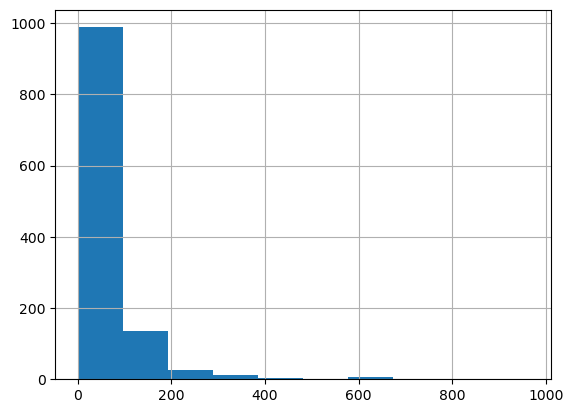

In [24]:

bottle_retention = bottle_purchases[
    bottle_purchases["filter_retention_days"].notna()
].copy()

import matplotlib.pyplot as plt

bottle_retention["filter_retention_days"].hist()
plt.savefig("../plots/bottle_filter_retention.png")

bottle_retention.to_csv("../data/computed/bottle_filter_retention.csv")


In [25]:
bottle_retention_by_customer = (
    bottle_retention
    .groupby(CUST_COL)["filter_retention_days"]
    .median()
    .rename("bottle_filter_retention_days")
    .reset_index()
)

bottle_retention_by_customer.head()


,Anon,bottle_filter_retention_days
0,ANON_0006,26.500000
1,ANON_0007,94.500000
2,ANON_0012,35.666667
3,ANON_0020,46.333333
4,ANON_0030,19.607143
